In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

Text(0, 0.5, 'Precipitation')

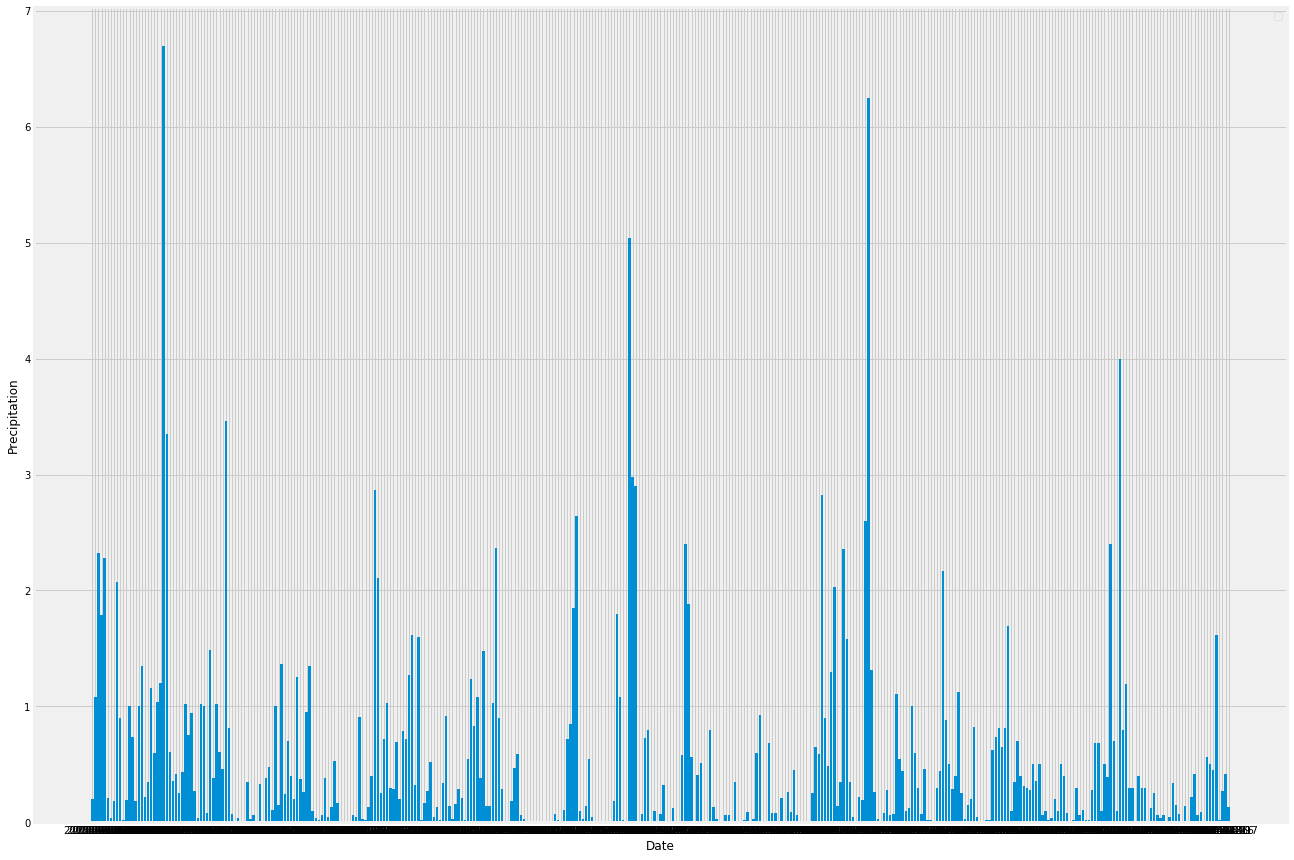

In [91]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
#results = session.query(Measurement.date,Measurement.prcp,Station.station).filter(Station.station==Measurement.station).filter(Measurement.date.like('2017%')).all()
results=engine.execute("SELECT Measurement.date,Measurement.prcp,Station.station,Measurement.tobs FROM Station\
 INNER JOIN Measurement ON Station.station=Measurement.station WHERE Measurement.date LIKE '2016-08-2%' OR Measurement.date LIKE '2016-09%' OR Measurement.date LIKE '2016-10%' OR Measurement.date LIKE '2016-11%' OR Measurement.date LIKE '2016-12%' OR Measurement.date LIKE '2017%'").fetchall()
# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores
precipitation = [str(result[1]) for result in results]
date = [str(result[0]) for result in results]
# Save the query results as a Pandas DataFrame and set the index to the date column
df=pd.DataFrame(results,columns=["Date","Precipitation","Station","Temperature"])
# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(20,15))
plt.bar(df["Date"],df["Precipitation"])
plt.xlabel("Date")
plt.ylabel("Precipitation")





![precipitation](Images/precipitation.png)

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precipitation,Temperature
count,2026.000000,2235.000000
mean,0.179003,74.599105
std,0.461658,4.613960
min,0.000000,58.000000
25%,0.000000,72.000000
50%,0.020000,75.000000
75%,0.130000,78.000000
max,6.700000,87.000000


![describe](Images/describe.png)

In [12]:
# Design a query to show how many stations are available in this dataset?
df["Station"].nunique()

7

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
df2=df.groupby("Station").count().sort_values(['Date'], ascending=False)
df2

,Date,Precipitation,Temperature
Station,,,
USC00519397,362,360,362
USC00519281,353,353,353
USC00516128,350,329,350
USC00513117,344,344,344
USC00519523,338,315,338
USC00514830,306,266,306
USC00517948,182,59,182


In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
result1= engine.execute("SELECT max(tobs),min(tobs),avg(tobs) FROM Measurement WHERE Station = 'USC00519397'").fetchall()
result1

[(87.0, 56.0, 74.55323054331865)]

Text(0, 0.5, 'Frequency')

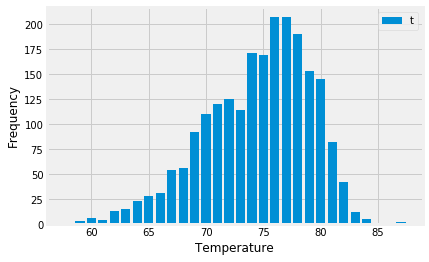

In [83]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results2=engine.execute("SELECT tobs,count(tobs) FROM Measurement WHERE station='USC00519397' AND date LIKE '2016-08-2%' OR date LIKE '2016-09%' OR date LIKE '2016-10%' OR date LIKE '2016-11%' OR date LIKE '2016-12%' OR date LIKE '2017%' GROUP BY tobs").fetchall()
results2
Temperature = [int(result[0]) for result in results2]
Frequency = [int(result[1]) for result in results2]
tempdf=pd.DataFrame(results2,columns=["Temperature","Frequency"])
plt.bar(tempdf["Temperature"],tempdf["Frequency"])
plt.legend("tobs", loc='upper right')
plt.xlabel("Temperature")
plt.ylabel("Frequency")

![precipitation](Images/station-histogram.png)

In [27]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [28]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
PreviousYear=calc_temps('2016-08-23','2017-08-23')
print(PreviousYear)

[(58.0, 74.59058295964125, 87.0)]


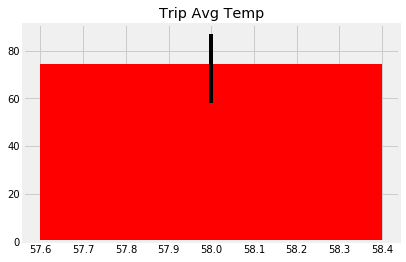

In [90]:
# Plot the results from your previous query as a bar chart. 
plt.bar(PreviousYear[0][0],PreviousYear[0][1],color='red')
# Use "Trip Avg Temp" as your Title
plt.title("Trip Avg Temp")
# Use the average temperature for the y value
plt.errorbar(PreviousYear[0][0],list,yerr=None,color='black')
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
list=[]
list.append(PreviousYear[0][0])
list.append(PreviousYear[0][2])

In [93]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
results3=engine.execute("SELECT sum(Measurement.prcp),Station.name,Station.station,Station.latitude,Station.longitude,Station.elevation FROM Station\
 INNER JOIN Measurement ON Station.station=Measurement.station WHERE Measurement.date LIKE '2016-08-2%' OR Measurement.date LIKE '2016-09%' OR Measurement.date LIKE '2016-10%' OR Measurement.date LIKE '2016-11%' OR Measurement.date LIKE '2016-12%' OR Measurement.date LIKE '2017%' GROUP BY Station.name ORDER BY sum(Measurement.prcp) DESC").fetchall()
print(results3)

[(147.78000000000006, 'MANOA LYON ARBO 785.2, HI US', 'USC00516128', 21.3331, -157.8025, 152.4), (72.32000000000001, 'WAIHEE 837.5, HI US', 'USC00519281', 21.45167, -157.84888999999998, 32.9), (49.70000000000003, 'KANEOHE 838.1, HI US', 'USC00513117', 21.4234, -157.8015, 14.6), (38.57, 'WAIMANALO EXPERIMENTAL FARM, HI US', 'USC00519523', 21.33556, -157.71139, 19.5), (33.239999999999995, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 'USC00514830', 21.5213, -157.8374, 7.0), (16.479999999999993, 'WAIKIKI 717.2, HI US', 'USC00519397', 21.2716, -157.8168, 3.0), (4.569999999999999, 'PEARL CITY, HI US', 'USC00517948', 21.3934, -157.9751, 11.9)]


## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
